# Set-up

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

# Import data

In [180]:
scapis = pd.read_csv('data/processed_data/scapis_joined_preprocessed.csv')
igt = pd.read_csv('data/processed_data/igt_joined_preprocessed.csv')
metadata = pd.read_csv('data/processed_data/metadata_preprocessed.csv')

In [181]:
igt_in = igt.drop(columns=['DAid'])
igt_in['Sex'] = igt_in['Sex'].map({'F': 0, 'M': 1})
igt_in['Smoke_status'] = igt_in['Smoke_status'].map({'NEVER': 0, 'EX_SMOKER': 1, 'CURRENT': 2})

igt_in.head()

,Sex,Age,Smoke_status,MAP_Mean,HbA1c,Chol,LDL,HDL,TG,ALT,...,GUSB,SCARF1,CELA3A,CCN3,HYOU1,LILRB2,ST6GAL1,TIE1,SIRPA,CASP3
0,0,59,1,78,35,4.7,3.0,1.90,0.76,0.19,...,-0.5040,-0.2106,0.0820,-0.0710,0.1003,0.1606,-0.4113,-2.0221,-0.3631,-1.1320
1,0,57,0,131,33,4.9,2.9,1.70,1.50,0.40,...,-0.3155,0.3637,0.7343,0.2531,0.0328,0.3409,-0.2604,0.2079,-1.0626,0.0286
2,1,51,1,103,42,6.8,3.6,0.98,4.30,0.54,...,2.0403,0.7059,0.8228,0.7173,0.1993,-0.0336,0.1411,0.8053,-0.0228,0.3960
3,0,54,1,92,34,7.2,5.4,1.40,2.00,0.33,...,-0.3515,0.0699,1.0066,0.6701,0.1653,-0.0150,0.3154,-0.0527,0.3685,-0.0582
4,1,54,2,83,37,4.2,2.8,0.96,0.81,0.49,...,-0.1522,0.2425,0.9367,0.1271,0.1272,0.1541,0.0736,-0.0461,-0.8490,-0.8921


# Neural Network

In [182]:
class Model(nn.Module):
    def __init__(self, in_features=1488, h1=256, h2=64, out_features=2):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [183]:
torch.manual_seed(123)
model = Model()

In [184]:
X = igt_in.drop(columns=['Obesity'])
y = igt_in['Obesity']

In [185]:
# Convert to numpy arrays
X = X.values
y = y.values

In [186]:
y

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [188]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [189]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [190]:
epochs = 50
losses = []

for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criteria(y_pred, y_train)
    losses.append(loss.detach().numpy())  # Detach the tensor to get the value as numpy array
    if i % 10 == 0:
        print(f'Epoch {i} and loss is: {loss}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0 and loss is: 0.6311995983123779
Epoch 10 and loss is: 0.565320611000061
Epoch 20 and loss is: 0.44433674216270447
Epoch 30 and loss is: 0.36241012811660767
Epoch 40 and loss is: 0.28952476382255554


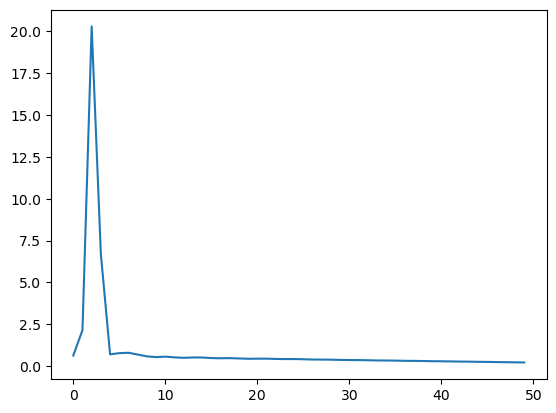

In [191]:
plt.plot(range(epochs), losses)

In [192]:
with torch.no_grad():  # Turn off backpropagation
    y_eval = model.forward(X_test)
    loss = criteria(y_eval, y_test)
    print(f'Loss: {loss}')

    correct = 0
    for i in range(len(y_test)):
        if torch.argmax(y_eval[i]) == y_test[i]:
            correct += 1

    print(f'We got {correct} correct! Accuracy: {correct/len(y_test)}')

Loss: 0.34461742639541626
We got 327 correct! Accuracy: 0.862796833773087


In [ ]:
#torch.save(model.state_dict(), 'models/obesity_nn.pth')